<a href="https://colab.research.google.com/github/srv-sh/Siamese-Network-with-Triplet-Loss-in-Keras-/blob/master/Siamese_Network_with_Triplet_Loss_in_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf

import keras
import matplotlib.pyplot as plt
import numpy as np
import random
#from pca_plotter import PCAPlotter

In [ ]:
#import the data
(x_train,y_train),(x_test , y_test) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
print(x_train.shape)

(60000, 28, 28)


In [ ]:
#normalizing 
x_train = np.reshape(x_train , (60000,784))/255.
x_test = np.reshape(x_test , (10000,784))/255.
print(x_train.shape)

(60000, 784)


In [ ]:
#ploting data

In [ ]:
def plot_triplet(triplet):
  plt.figure(figsize =(6,2))
  for i in range(0,3):
    plt.subplot(1,3, i+1)
    plt.imshow(np.reshape(triplet[i],(28,28)) , cmap = 'binary')
    plt.xticks([])
    plt.yticks([])
  plt.show()

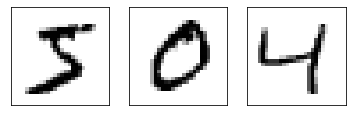

In [ ]:
plot_triplet([x_train[0],x_train[1],x_train[2]])

In [ ]:
# a batch of triplets
def create_batch(batch_size):
  anchors = np.zeros((batch_size,784))
  positives =np.zeros((batch_size,784))
  negatives = np.zeros((batch_size,784))

  for i in range(0, batch_size):
    index = random.randint(0 , 60000 -1)
    anc = x_train[index]
    y = y_train[index]

    indices_for_pos = np.squeeze(np.where(y_train == y))
    indices_for_neg = np.squeeze(np.where(y_train != y))

    pos = x_train[indices_for_pos[random.randint(0,len(indices_for_pos) - 1)]]
    neg = x_train[indices_for_neg[random.randint(0,len(indices_for_neg) - 1)]]

    anchors[i] = anc
    positives[i] = pos
    negatives[i] = neg

  return [anchors , positives , negatives]


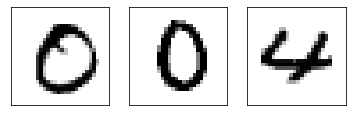

In [ ]:
triplet = create_batch(1)
plot_triplet(triplet)

In [ ]:
#embading model
emb_dim = 64
model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(64,activation='relu',input_shape=(784,)),
        tf.keras.layers.Dense(emb_dim , activation='sigmoid')
])
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 64)                50240     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
Total params: 54,400
Trainable params: 54,400
Non-trainable params: 0
_________________________________________________________________


In [ ]:
example = x_train[0]
example_emb = model.predict(np.expand_dims(example , axis = 0))[0]

In [ ]:
example_emb

array([0.49985287, 0.50025064, 0.50009555, 0.5003762 , 0.5005306 ,
       0.4997475 , 0.5000504 , 0.50021666, 0.5005744 , 0.49984735,
       0.50045866, 0.49984473, 0.49978527, 0.5007147 , 0.49942237,
       0.500041  , 0.49994326, 0.5002609 , 0.5001118 , 0.4995798 ,
       0.49924642, 0.499728  , 0.49950755, 0.4993564 , 0.4999435 ,
       0.5004932 , 0.49986318, 0.50068635, 0.5000878 , 0.5001537 ,
       0.49991405, 0.49989048, 0.5001761 , 0.50000286, 0.50001305,
       0.5001861 , 0.49969506, 0.4998894 , 0.5001283 , 0.49974465,
       0.50064653, 0.5002011 , 0.5005037 , 0.5002195 , 0.5000189 ,
       0.49981862, 0.49952862, 0.49984932, 0.50040454, 0.49916545,
       0.5002494 , 0.4995429 , 0.5001902 , 0.49997604, 0.50000113,
       0.50016177, 0.49990883, 0.50003314, 0.5003638 , 0.49979267,
       0.5001399 , 0.5005984 , 0.5004387 , 0.49992216], dtype=float32)

In [ ]:
#siamese network 

In [ ]:
in_anc = tf.keras.layers.Input(shape=(784,))
in_pos = tf.keras.layers.Input(shape=(784,))
in_neg = tf.keras.layers.Input(shape=(784,))

em_anc = model(in_anc)
em_pos = model(in_pos)
em_neg = model(in_neg)

out = tf.keras.layers.concatenate([em_anc , em_pos , em_neg], axis=1 )

net = tf.keras.models.Model(
    [in_anc , in_pos , in_neg],
    out
)
net.summary()


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 64)           54400       input_1[0][0]                    
                                                                 input_2[0][0]         

In [ ]:
#triple loss
def triplet_loss(alpha , emb_dim):
  def loss(y_true , y_pred):
    anc , pos , neg = y_pred[:, :emb_dim] , y_pred[:, emb_dim: 2*emb_dim] ,y_pred[:, 2*emb_dim:]
    dp = tf.reduce_mean(tf.square(anc - pos), axis =1)
    dn = tf.reduce_mean(tf.square(anc - neg), axis =1)
    return tf.maximum(dp - dn +alpha , 0.)
  return loss

In [ ]:
# Data generator
def data_generator(batch_size, emb_dim):
  while True:
    x = create_batch(batch_size)
    y= np.zeros((batch_size , 3*emb_dim))
    yield x, y
    

In [ ]:
#model training 
batch_size = 1024
epochs =10 
steps_per_epoch = int(60000/ batch_size)

net.compile(loss = triplet_loss(alpha=0.2, emb_dim= emb_dim), optimizer= 'adam',metrics=['accuracy'])

X,Y  = x_test[:1000] , y_test[:1000]

In [ ]:
history = net.fit(
    data_generator(batch_size , emb_dim) ,
    epochs =  epochs , steps_per_epoch = steps_per_epoch,
    validation_split=0.2,
    verbose =False,
  
)

NameError: ignored

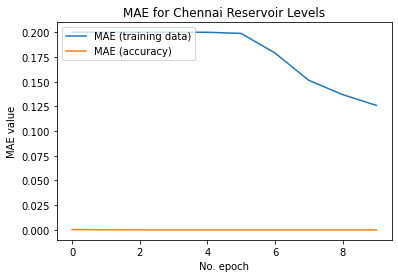

In [ ]:
# Plot history: MAE
plt.plot(history.history['loss'], label='MAE (training data)')
plt.plot(history.history['accuracy'], label='MAE (accuracy)')
plt.title('MAE for Chennai Reservoir Levels')
plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()